**Проект "Прогнозирование температуры плавления стали"**

## Условия задания

Чтобы оптимизировать производственные расходы, металлургический комбинат ООО «Так закаляем сталь» решил уменьшить потребление электроэнергии на этапе обработки стали. Предстоит построить модель, которая предскажет температуру стали.

### Описание этапа обработки

Сталь обрабатывают в металлическом ковше вместимостью около 100 тонн. Чтобы ковш выдерживал высокие температуры, изнутри его облицовывают огнеупорным кирпичом. Расплавленную сталь заливают в ковш и подогревают до нужной температуры графитовыми электродами. Они установлены в крышке ковша. 

Из сплава выводится сера (десульфурация), добавлением примесей корректируется химический состав и отбираются пробы. Сталь легируют — изменяют её состав — подавая куски сплава из бункера для сыпучих материалов или проволоку через специальный трайб-аппарат (англ. tribe, «масса»).

Перед тем как первый раз ввести легирующие добавки, измеряют температуру стали и производят её химический анализ. Потом температуру на несколько минут повышают, добавляют легирующие материалы и продувают сплав инертным газом. Затем его перемешивают и снова проводят измерения. Такой цикл повторяется до достижения целевого химического состава и оптимальной температуры плавки.

Тогда расплавленная сталь отправляется на доводку металла или поступает в машину непрерывной разливки. Оттуда готовый продукт выходит в виде заготовок-слябов (англ. *slab*, «плита»).

### Описание данных

Данные состоят из файлов, полученных из разных источников:

- `data_arc.csv` — данные об электродах;
- `data_bulk.csv` — данные о подаче сыпучих материалов (объём);
- `data_bulk_time.csv` *—* данные о подаче сыпучих материалов (время);
- `data_gas.csv` — данные о продувке сплава газом;
- `data_temp.csv` — результаты измерения температуры;
- `data_wire.csv` — данные о проволочных материалах (объём);
- `data_wire_time.csv` — данные о проволочных материалах (время).

Во всех файлах столбец `key` содержит номер партии. В файлах может быть несколько строк с одинаковым значением `key`: они соответствуют разным итерациям обработки.

Данные находятся в тренажёре, в папке /datasets/final_steel/.

### План работы:

* Подготовка и анализ данных
    * Импортируем необходимые библиотеки
    * Загрузим датасет
    * Проведем первичный осмотр датасета
    * Определим пропуски и дубликаты
    * Проверим данные на аномальность

* Предобработка данных
    * Заполним пропуски
    * Изменим формат данных в некоторых столбцах если потребуется
    * Уберем объекты, не имеющие достаточно признаков для изучения если потребуется
    * Проверим признаки на мультиколлиниарность

* Обучение моделей
    * Затем, подготовим датасет для обучения
    * Определим целевой признак
    * Поделим датасет на выборки: Обучающаю и тестовую
    * Выберем 3 модели для работы: Linear Regression, Random Forest, LGBMRegression
    * Обучим каждую модель и предскажем на тестовой выборке
    * Сравним результаты по метрике MAE
    * Определим важность признаков для каждой модели
    
* Вывод
    * Определим лучшую модель и результат метрики
    * На основе анализа сформируем доводы и напишем вывод

## Подготовка и анализ данных

### Импорт необходимых библиотек

In [1]:
import pandas as pd
import numpy as np
import warnings
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats as st
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from pyod.models.knn import KNN
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from xgboost import plot_importance

warnings.filterwarnings('ignore')

### Загрузка датасета

Учитывая данные, будем использовать функцию для просмотра значений внутри столбцов.

In [2]:
def show_rows(data_frame):
    for column in data_frame.columns:
        print('Уникальные значения по столбцам', column)
        print(data_frame[column].sort_values().unique())

### Посмотрим данные по каждой таблице для первичного анализа данных.

#### Данные об электродах

In [3]:
data_arc = pd.read_csv('/datasets/final_steel/data_arc.csv')
data_arc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
key                     14876 non-null int64
Начало нагрева дугой    14876 non-null object
Конец нагрева дугой     14876 non-null object
Активная мощность       14876 non-null float64
Реактивная мощность     14876 non-null float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB


In [4]:
show_rows(data_arc)

Уникальные значения по столбцам key
[   1    2    3 ... 3239 3240 3241]
Уникальные значения по столбцам Начало нагрева дугой
['2019-05-03 11:02:14' '2019-05-03 11:07:28' '2019-05-03 11:11:44' ...
 '2019-09-01 04:16:41' '2019-09-01 04:31:51' '2019-09-01 04:34:47']
Уникальные значения по столбцам Конец нагрева дугой
['2019-05-03 11:06:02' '2019-05-03 11:10:33' '2019-05-03 11:14:36' ...
 '2019-09-01 04:19:45' '2019-09-01 04:32:48' '2019-09-01 04:36:08']
Уникальные значения по столбцам Активная мощность
[0.03000194 0.03018816 0.0301905  ... 3.15076178 3.15627646 3.73159611]
Уникальные значения по столбцам Реактивная мощность
[-7.15504924e+02  2.08063126e-02  2.11541653e-02 ...  2.45995915e+00
  2.50420606e+00  2.67638755e+00]


In [5]:
len(data_arc['key'].unique())

3214

In [6]:
data_arc['key'].value_counts()

2108    16
1689    15
1513    15
2567    14
322     13
        ..
614      1
1914     1
2025     1
2795     1
1568     1
Name: key, Length: 3214, dtype: int64

count    14876.000000
mean         0.670441
std          0.408159
min          0.030002
25%          0.395297
50%          0.555517
75%          0.857034
max          3.731596
Name: Активная мощность, dtype: float64

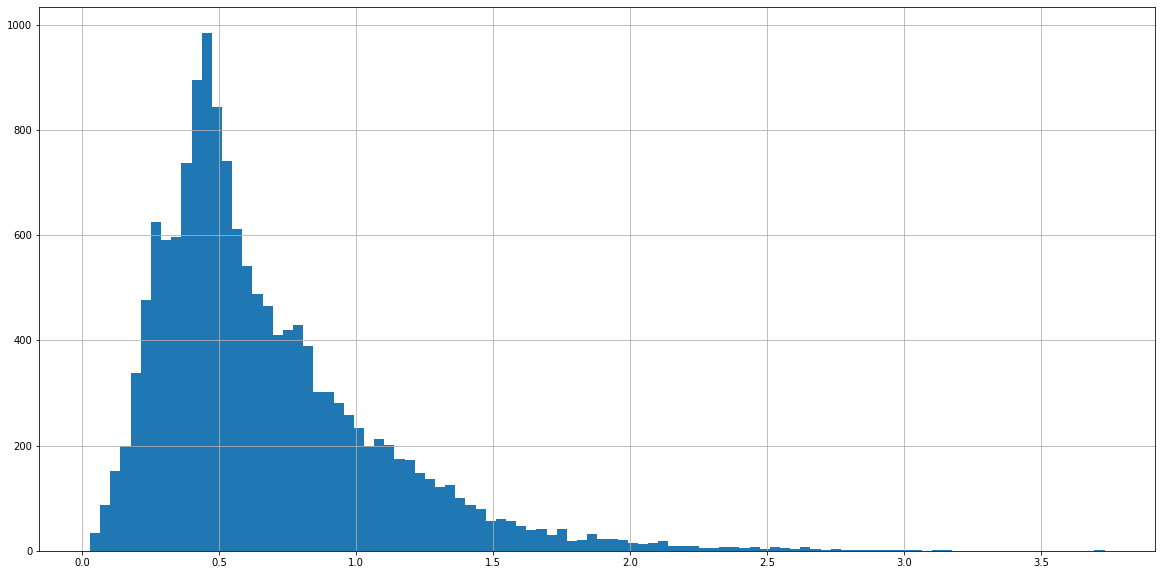

In [7]:
display(data_arc['Активная мощность'].describe())
data_arc['Активная мощность'].hist(bins=100, figsize=(20,10))

count    14876.000000
mean         0.452592
std          5.878702
min       -715.504924
25%          0.290991
50%          0.415962
75%          0.637371
max          2.676388
Name: Реактивная мощность, dtype: float64

count    14875.000000
mean         0.500723
std          0.310880
min          0.020806
25%          0.291003
50%          0.415984
75%          0.637403
max          2.676388
Name: Реактивная мощность, dtype: float64

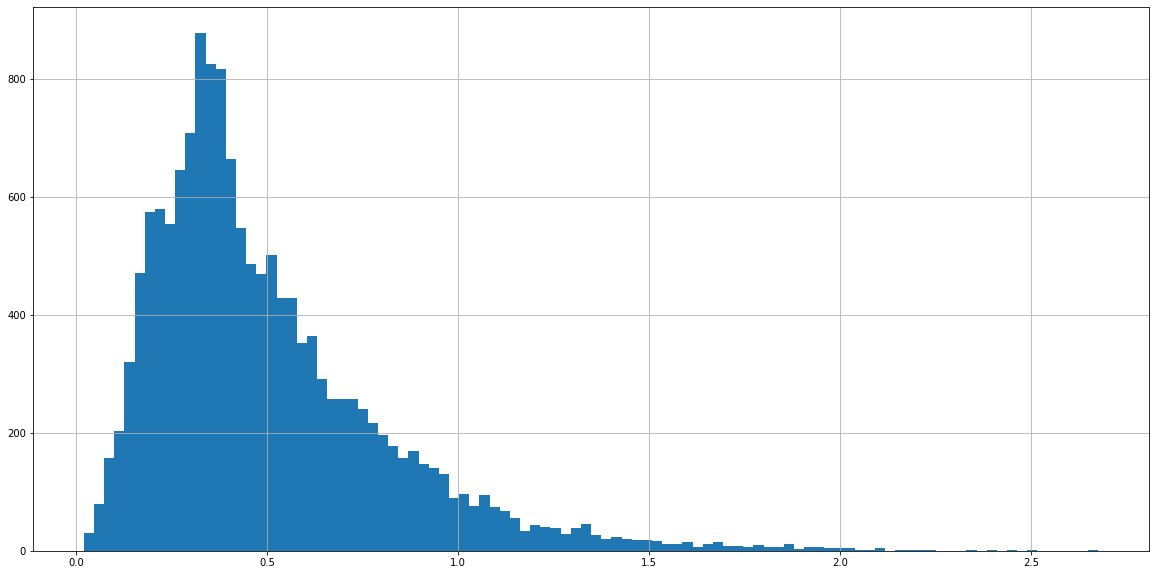

In [8]:
display(data_arc['Реактивная мощность'].describe())
display(data_arc[data_arc['Реактивная мощность'] > 0]['Реактивная мощность'].describe())
data_arc[data_arc['Реактивная мощность'] > 0]['Реактивная мощность'].hist(bins=100, figsize=(20,10))

#### Данные о подаче сыпучих материалов (объём)

In [9]:
data_bulk = pd.read_csv('/datasets/final_steel/data_bulk.csv')
data_bulk.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
key        3129 non-null int64
Bulk 1     252 non-null float64
Bulk 2     22 non-null float64
Bulk 3     1298 non-null float64
Bulk 4     1014 non-null float64
Bulk 5     77 non-null float64
Bulk 6     576 non-null float64
Bulk 7     25 non-null float64
Bulk 8     1 non-null float64
Bulk 9     19 non-null float64
Bulk 10    176 non-null float64
Bulk 11    177 non-null float64
Bulk 12    2450 non-null float64
Bulk 13    18 non-null float64
Bulk 14    2806 non-null float64
Bulk 15    2248 non-null float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


In [10]:
show_rows(data_bulk)

Уникальные значения по столбцам key
[   1    2    3 ... 3239 3240 3241]
Уникальные значения по столбцам Bulk 1
[ 10.  16.  19.  21.  22.  24.  26.  27.  28.  29.  30.  31.  32.  33.
  34.  36.  37.  38.  39.  41.  43.  44.  46.  47.  48.  50.  51.  52.
  54.  58.  60.  62.  63.  65.  67.  69.  73.  74.  75.  78.  83.  90.
  92.  94. 104. 118. 185.  nan]
Уникальные значения по столбцам Bulk 2
[228. 232. 233. 236. 242. 246. 247. 248. 249. 254. 257. 258. 270. 282.
 325.  nan]
Уникальные значения по столбцам Bulk 3
[  6.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.  28.  29.
  30.  31.  32.  34.  36.  37.  38.  39.  40.  41.  42.  43.  44.  45.
  46.  47.  48.  49.  50.  51.  52.  53.  54.  55.  56.  57.  58.  59.
  60.  61.  62.  63.  64.  65.  66.  67.  68.  69.  70.  71.  72.  73.
  74.  75.  76.  77.  78.  79.  80.  81.  82.  83.  84.  85.  86.  87.
  88.  89.  90.  91.  92.  93.  94.  95.  96.  97.  98.  99. 100. 101.
 102. 103. 104. 105. 106. 107. 108. 109. 110. 111. 112. 1

In [11]:
len(data_bulk['key'].unique())

3129

In [12]:
data_bulk['key'].value_counts()

2047    1
1070    1
1092    1
3139    1
1090    1
       ..
2590    1
541     1
2588    1
539     1
2049    1
Name: key, Length: 3129, dtype: int64

Bulk 1


count    252.000000
mean      39.242063
std       18.277654
min       10.000000
25%       27.000000
50%       31.000000
75%       46.000000
max      185.000000
Name: Bulk 1, dtype: float64

Bulk 2


count     22.000000
mean     253.045455
std       21.180578
min      228.000000
25%      242.000000
50%      251.500000
75%      257.750000
max      325.000000
Name: Bulk 2, dtype: float64

Bulk 3


count    1298.000000
mean      113.879045
std        75.483494
min         6.000000
25%        58.000000
50%        97.500000
75%       152.000000
max       454.000000
Name: Bulk 3, dtype: float64

Bulk 4


count    1014.000000
mean      104.394477
std        48.184126
min        12.000000
25%        72.000000
50%       102.000000
75%       133.000000
max       281.000000
Name: Bulk 4, dtype: float64

Bulk 5


count     77.000000
mean     107.025974
std       81.790646
min       11.000000
25%       70.000000
50%       86.000000
75%      132.000000
max      603.000000
Name: Bulk 5, dtype: float64

Bulk 6


count    576.000000
mean     118.925347
std       72.057776
min       17.000000
25%       69.750000
50%      100.000000
75%      157.000000
max      503.000000
Name: Bulk 6, dtype: float64

Bulk 7


count     25.000000
mean     305.600000
std      191.022904
min       47.000000
25%      155.000000
50%      298.000000
75%      406.000000
max      772.000000
Name: Bulk 7, dtype: float64

Bulk 8


count     1.0
mean     49.0
std       NaN
min      49.0
25%      49.0
50%      49.0
75%      49.0
max      49.0
Name: Bulk 8, dtype: float64

Bulk 9


count     19.000000
mean      76.315789
std       21.720581
min       63.000000
25%       66.000000
50%       68.000000
75%       70.500000
max      147.000000
Name: Bulk 9, dtype: float64

Bulk 10


count    176.000000
mean      83.284091
std       26.060347
min       24.000000
25%       64.000000
50%       86.500000
75%      102.000000
max      159.000000
Name: Bulk 10, dtype: float64

Bulk 11


count    177.000000
mean      76.819209
std       59.655365
min        8.000000
25%       25.000000
50%       64.000000
75%      106.000000
max      313.000000
Name: Bulk 11, dtype: float64

Bulk 12


count    2450.000000
mean      260.471020
std       120.649269
min        53.000000
25%       204.000000
50%       208.000000
75%       316.000000
max      1849.000000
Name: Bulk 12, dtype: float64

Bulk 13


count     18.000000
mean     181.111111
std       46.088009
min      151.000000
25%      153.250000
50%      155.500000
75%      203.500000
max      305.000000
Name: Bulk 13, dtype: float64

Bulk 14


count    2806.000000
mean      170.284747
std        65.868652
min        16.000000
25%       119.000000
50%       151.000000
75%       205.750000
max       636.000000
Name: Bulk 14, dtype: float64

Bulk 15


count    2248.000000
mean      160.513345
std        51.765319
min         1.000000
25%       105.000000
50%       160.000000
75%       205.000000
max       405.000000
Name: Bulk 15, dtype: float64

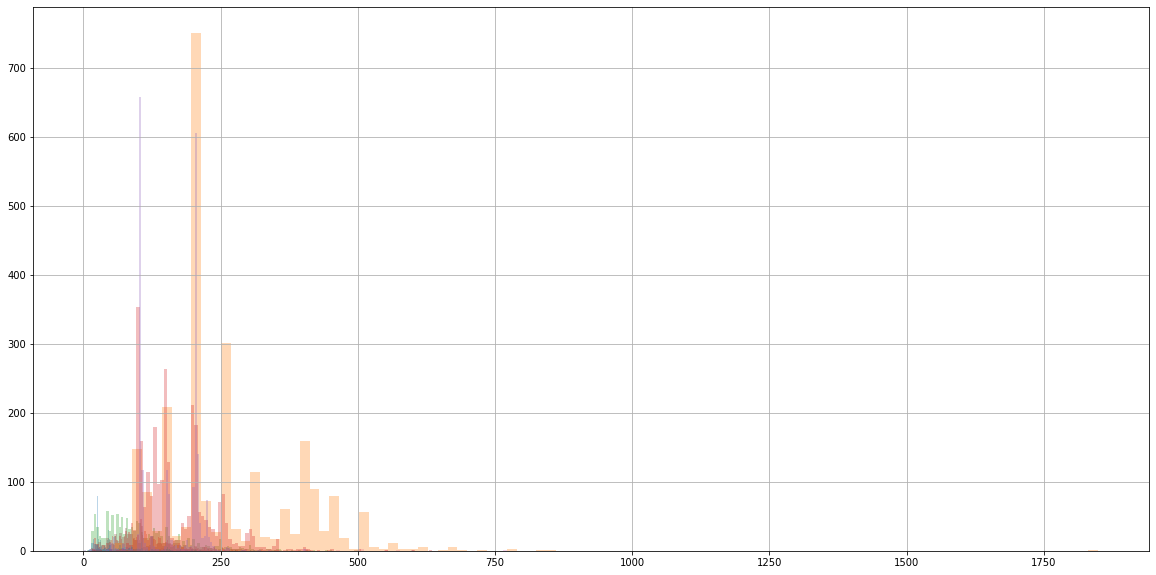

In [13]:
for column in data_bulk.columns:
    if column[0] == 'B':
        print(column)
        display(data_bulk[column].describe())
        data_bulk[column].hist(bins=100, figsize=(20,10), alpha=0.3)

#### Данные о подаче сыпучих материалов (время)

In [14]:
data_bulk_time = pd.read_csv('/datasets/final_steel/data_bulk_time.csv')
data_bulk_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
key        3129 non-null int64
Bulk 1     252 non-null object
Bulk 2     22 non-null object
Bulk 3     1298 non-null object
Bulk 4     1014 non-null object
Bulk 5     77 non-null object
Bulk 6     576 non-null object
Bulk 7     25 non-null object
Bulk 8     1 non-null object
Bulk 9     19 non-null object
Bulk 10    176 non-null object
Bulk 11    177 non-null object
Bulk 12    2450 non-null object
Bulk 13    18 non-null object
Bulk 14    2806 non-null object
Bulk 15    2248 non-null object
dtypes: int64(1), object(15)
memory usage: 391.2+ KB


In [15]:
show_rows(data_bulk_time)

Уникальные значения по столбцам key
[   1    2    3 ... 3239 3240 3241]
Уникальные значения по столбцам Bulk 1
['2019-05-03 17:50:19' '2019-05-05 10:09:13' '2019-05-05 11:01:42'
 '2019-05-05 11:59:23' '2019-05-05 13:13:45' '2019-05-05 14:17:04'
 '2019-05-05 15:03:54' '2019-05-05 16:00:33' '2019-05-05 20:49:32'
 '2019-05-07 11:24:41' '2019-05-07 15:37:52' '2019-05-07 16:15:34'
 '2019-05-07 17:35:13' '2019-05-08 01:00:11' '2019-05-08 05:26:23'
 '2019-05-08 10:05:03' '2019-05-08 10:39:56' '2019-05-08 11:33:17'
 '2019-05-08 15:14:16' '2019-05-09 04:35:17' '2019-05-10 16:46:26'
 '2019-05-10 17:16:52' '2019-05-10 18:41:05' '2019-05-10 20:05:32'
 '2019-05-11 10:46:17' '2019-05-11 12:15:55' '2019-05-11 17:50:54'
 '2019-05-12 15:36:08' '2019-05-12 16:43:26' '2019-05-12 21:33:11'
 '2019-05-13 13:14:48' '2019-05-13 14:36:57' '2019-05-14 12:01:34'
 '2019-05-14 14:09:52' '2019-05-14 16:24:02' '2019-05-14 21:58:07'
 '2019-05-15 09:27:40' '2019-05-15 15:05:04' '2019-05-15 21:42:31'
 '2019-05-15 23:52

In [16]:
len(data_bulk_time['key'].unique())

3129

In [17]:
data_bulk_time['key'].value_counts()

2047    1
1070    1
1092    1
3139    1
1090    1
       ..
2590    1
541     1
2588    1
539     1
2049    1
Name: key, Length: 3129, dtype: int64

#### Данные о продувке сплава газом

In [18]:
data_gas = pd.read_csv('/datasets/final_steel/data_gas.csv')
data_gas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
key      3239 non-null int64
Газ 1    3239 non-null float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


In [19]:
show_rows(data_gas)

Уникальные значения по столбцам key
[   1    2    3 ... 3239 3240 3241]
Уникальные значения по столбцам Газ 1
[8.39852910e-03 1.66956024e-02 2.63028954e-01 ... 5.21423726e+01
 6.09356892e+01 7.79950397e+01]


In [20]:
len(data_gas['key'].unique())

3239

In [21]:
data_gas['key'].value_counts()

2047    1
2580    1
2600    1
549     1
2596    1
       ..
3119    1
1070    1
3115    1
1066    1
2049    1
Name: key, Length: 3239, dtype: int64

count    3239.000000
mean       11.002062
std         6.220327
min         0.008399
25%         7.043089
50%         9.836267
75%        13.769915
max        77.995040
Name: Газ 1, dtype: float64

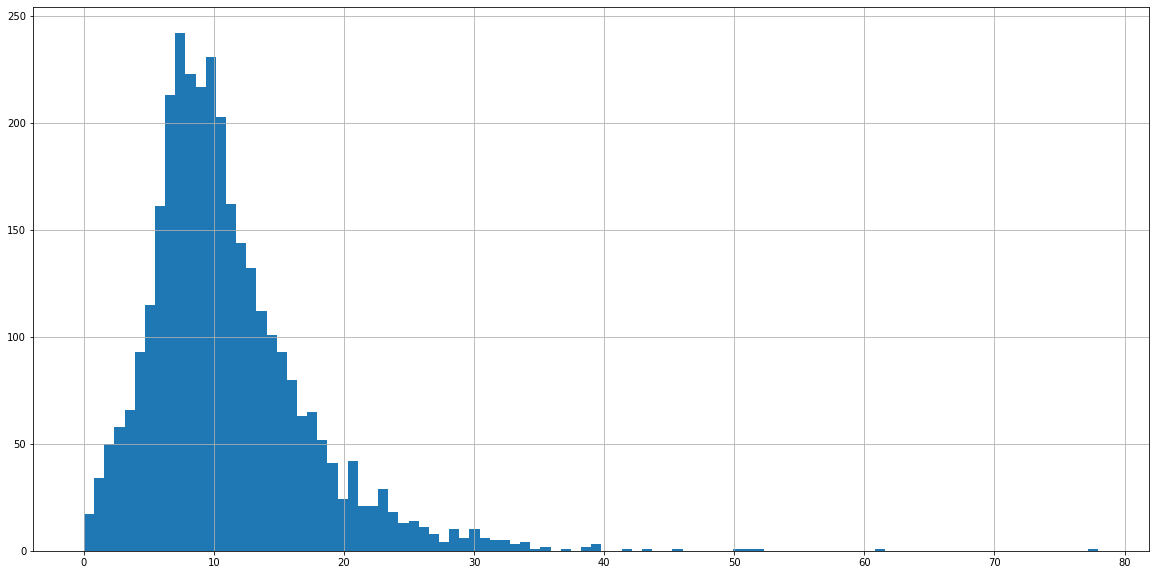

In [22]:
display(data_gas['Газ 1'].describe())
data_gas['Газ 1'].hist(bins=100, figsize=(20,10))

#### Результаты измерения температуры

In [23]:
data_temp = pd.read_csv('/datasets/final_steel/data_temp.csv')
data_temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15907 entries, 0 to 15906
Data columns (total 3 columns):
key             15907 non-null int64
Время замера    15907 non-null object
Температура     13006 non-null float64
dtypes: float64(1), int64(1), object(1)
memory usage: 372.9+ KB


In [24]:
show_rows(data_temp)

Уникальные значения по столбцам key
[   1    2    3 ... 3239 3240 3241]
Уникальные значения по столбцам Время замера
['2019-05-03 11:16:18' '2019-05-03 11:25:53' '2019-05-03 11:29:11' ...
 '2019-09-01 04:22:39' '2019-09-01 04:33:42' '2019-09-01 04:38:08']
Уникальные значения по столбцам Температура
[1191. 1204. 1208. 1218. 1227. 1383. 1519. 1520. 1525. 1526. 1527. 1528.
 1529. 1530. 1531. 1532. 1533. 1534. 1535. 1536. 1537. 1538. 1539. 1540.
 1541. 1542. 1543. 1544. 1545. 1546. 1547. 1548. 1549. 1550. 1551. 1552.
 1553. 1554. 1555. 1556. 1557. 1558. 1559. 1560. 1561. 1562. 1563. 1564.
 1565. 1566. 1567. 1568. 1569. 1570. 1571. 1572. 1573. 1574. 1575. 1576.
 1577. 1578. 1579. 1580. 1581. 1582. 1583. 1584. 1585. 1586. 1587. 1588.
 1589. 1590. 1591. 1592. 1593. 1594. 1595. 1596. 1597. 1598. 1599. 1600.
 1601. 1602. 1603. 1604. 1605. 1606. 1607. 1608. 1609. 1610. 1611. 1612.
 1613. 1614. 1615. 1616. 1617. 1618. 1619. 1620. 1621. 1622. 1623. 1624.
 1625. 1626. 1627. 1628. 1629. 1630. 1631. 

In [25]:
len(data_temp['key'].unique())

3216

In [26]:
data_temp['key'].value_counts()

44      16
1214    16
1513    16
46      16
1689    15
        ..
1106     2
1424     2
3156     2
279      1
195      1
Name: key, Length: 3216, dtype: int64

count    13006.000000
mean      1591.840920
std         21.375851
min       1191.000000
25%       1581.000000
50%       1591.000000
75%       1601.000000
max       1705.000000
Name: Температура, dtype: float64

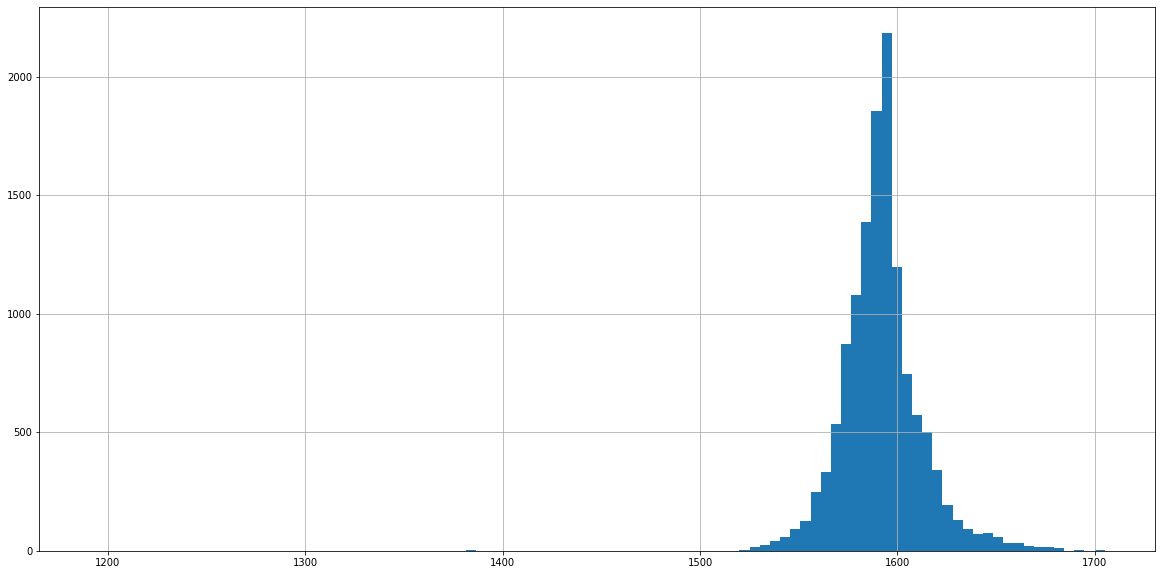

In [27]:
display(data_temp['Температура'].describe())
data_temp['Температура'].hist(bins=100, figsize=(20,10))

#### Данные о проволочных материалах (объём)

In [28]:
data_wire = pd.read_csv('/datasets/final_steel/data_wire.csv')
data_wire.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
key       3081 non-null int64
Wire 1    3055 non-null float64
Wire 2    1079 non-null float64
Wire 3    63 non-null float64
Wire 4    14 non-null float64
Wire 5    1 non-null float64
Wire 6    73 non-null float64
Wire 7    11 non-null float64
Wire 8    19 non-null float64
Wire 9    29 non-null float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


In [29]:
show_rows(data_wire)

Уникальные значения по столбцам key
[   1    2    3 ... 3239 3240 3241]
Уникальные значения по столбцам Wire 1
[  1.9188     2.09664    3.10128  ... 280.987214 330.314424        nan]
Уникальные значения по столбцам Wire 2
[3.01600000e-02 6.03200000e-02 9.04800000e-02 9.04800000e-02
 1.74720000e-01 5.82400000e-01 1.17624000e+00 1.60160000e+00
 2.74456000e+00 3.98112000e+00 4.10176000e+00 4.13192000e+00
 5.12720000e+00 7.72096000e+00 8.08288000e+00 8.11304000e+00
 8.17336000e+00 8.83688000e+00 9.01784000e+00 9.04800000e+00
 9.07816000e+00 9.08544100e+00 9.10832000e+00 9.11456000e+00
 9.13848000e+00 9.14368100e+00 9.16864000e+00 9.19880000e+00
 9.22896000e+00 9.31944000e+00 9.68136000e+00 1.00432800e+01
 1.00734400e+01 1.01036000e+01 1.01337590e+01 1.01337600e+01
 1.01639190e+01 1.01940790e+01 1.02242400e+01 1.10385600e+01
 1.10687200e+01 1.10988800e+01 1.11238400e+01 1.11290400e+01
 1.11592000e+01 1.11893600e+01 1.12195200e+01 1.20338400e+01
 1.20848000e+01 1.20941600e+01 1.21243200e+01 

In [30]:
len(data_wire['key'].unique())

3081

In [31]:
data_wire['key'].value_counts()

2047    1
1022    1
1092    1
3139    1
1090    1
       ..
2592    1
543     1
2590    1
541     1
2049    1
Name: key, Length: 3081, dtype: int64

Wire 1


count    3055.000000
mean      100.895853
std        42.012518
min         1.918800
25%        72.115684
50%       100.158234
75%       126.060484
max       330.314424
Name: Wire 1, dtype: float64

Wire 2


count    1079.000000
mean       50.577323
std        39.320216
min         0.030160
25%        20.193680
50%        40.142956
75%        70.227558
max       282.780152
Name: Wire 2, dtype: float64

Wire 3


count     63.000000
mean     189.482681
std       99.513444
min        0.144144
25%       95.135044
50%      235.194977
75%      276.252014
max      385.008668
Name: Wire 3, dtype: float64

Wire 4


count     14.000000
mean      57.442841
std       28.824667
min       24.148801
25%       40.807002
50%       45.234282
75%       76.124619
max      113.231044
Name: Wire 4, dtype: float64

Wire 5


count     1.000
mean     15.132
std         NaN
min      15.132
25%      15.132
50%      15.132
75%      15.132
max      15.132
Name: Wire 5, dtype: float64

Wire 6


count     73.000000
mean      48.016974
std       33.919845
min        0.034320
25%       25.053600
50%       42.076324
75%       64.212723
max      180.454575
Name: Wire 6, dtype: float64

Wire 7


count    11.000000
mean     10.039007
std       8.610584
min       0.234208
25%       6.762756
50%       9.017009
75%      11.886057
max      32.847674
Name: Wire 7, dtype: float64

Wire 8


count     19.000000
mean      53.625193
std       16.881728
min       45.076721
25%       46.094879
50%       46.279999
75%       48.089603
max      102.762401
Name: Wire 8, dtype: float64

Wire 9


count    29.000000
mean     34.155752
std      19.931616
min       4.622800
25%      22.058401
50%      30.066399
75%      43.862003
max      90.053604
Name: Wire 9, dtype: float64

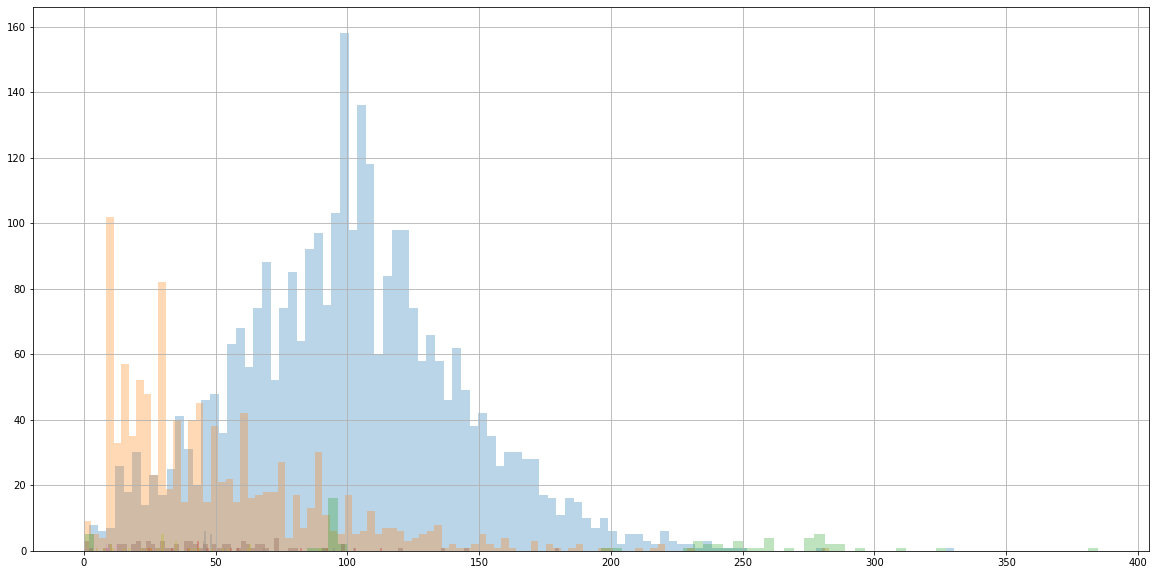

In [32]:
for column in data_wire.columns:
    if column[0] == 'W':
        print(column)
        display(data_wire[column].describe())
        data_wire[column].hist(bins=100, figsize=(20,10), alpha=0.3)

#### Данные о проволочных материалах (время)

In [33]:
data_wire_time = pd.read_csv('/datasets/final_steel/data_wire_time.csv')
data_wire_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
key       3081 non-null int64
Wire 1    3055 non-null object
Wire 2    1079 non-null object
Wire 3    63 non-null object
Wire 4    14 non-null object
Wire 5    1 non-null object
Wire 6    73 non-null object
Wire 7    11 non-null object
Wire 8    19 non-null object
Wire 9    29 non-null object
dtypes: int64(1), object(9)
memory usage: 240.8+ KB


In [34]:
show_rows(data_wire_time)

Уникальные значения по столбцам key
[   1    2    3 ... 3239 3240 3241]
Уникальные значения по столбцам Wire 1
['2019-05-03 11:11:41' '2019-05-03 11:46:10' '2019-05-03 12:13:47' ...
 '2019-09-01 03:12:02' '2019-09-01 04:16:01' nan]
Уникальные значения по столбцам Wire 2
['2019-05-03 13:32:06' '2019-05-03 13:59:54' '2019-05-03 15:58:12' ...
 '2019-08-31 13:14:22' '2019-08-31 18:50:15' nan]
Уникальные значения по столбцам Wire 3
['2019-05-04 04:47:53' '2019-05-04 05:40:08' '2019-05-07 08:50:29'
 '2019-05-07 10:17:14' '2019-05-07 15:50:31' '2019-05-07 16:34:12'
 '2019-05-07 17:43:23' '2019-05-07 21:58:49' '2019-05-07 22:40:07'
 '2019-05-07 23:27:46' '2019-05-18 13:04:48' '2019-05-18 13:41:36'
 '2019-05-18 20:52:18' '2019-05-18 21:49:12' '2019-06-02 20:37:44'
 '2019-06-08 16:23:31' '2019-06-10 13:19:54' '2019-06-10 14:05:33'
 '2019-06-10 14:25:42' '2019-06-12 01:29:02' '2019-06-12 20:11:25'
 '2019-06-12 21:27:01' '2019-07-07 18:33:17' '2019-07-07 19:25:35'
 '2019-07-07 20:16:17' '2019-07-0

In [35]:
len(data_wire_time['key'].unique())

3081

In [36]:
data_wire_time['key'].value_counts()

2047    1
1022    1
1092    1
3139    1
1090    1
       ..
2592    1
543     1
2590    1
541     1
2049    1
Name: key, Length: 3081, dtype: int64

### Промежуточный вывод

- Данные требуют предобработки и группировки по признаку key.
- Название столбцов нужно превести к английском языку прописными буквами и избавиться от пробелов.
- Пропуски значений в столбцах, вероятно, говорят об отсутствие действия/замера на этой стадии или же это ошибка датчика при передаче информации. 
- В таблицах data_bulk и data_wire указаны 15 и 9 столбцов о различных материалах вероятно, что в каждую партию может относится определенный набор из них и только единицам требуется использование всех возможных материалов.
- В таблицах разное количество уникальных номеров партии key, вероятно, что над ней не выполнялся определенный технологический этап.
- Есть столбцы, которые могут не использовать тип float, так как хранят только целые числа.
- Необходим перевод времени в формат datetime.
- Таблицы data_arc и data_temp обладают записями с одинаковыми значениями key в разное время применения технологической операции. Количество записей у одной партии для каждой таблицы может различаться.
- Аномальное значение реактивной мощности в таблице data_arc, свидетельствует о наличие ошибки.
- Данные распределеные об активной и реактивной мощности имеют нормальное распределение, со смещением влево.
- Данные о температуре имеют нормальное распределение, без смещения.

## Подготовка данных

Определим суммы значений активной и реактивной мощности

Составим из таблицы data_arc сгрупированную таблицу data_arc_sum по key для дальнейшего объединения данных. По факту, чем больше энергии было затрачено на нагрев, тем больше должна быть темпереатура.

In [37]:
data_arc.columns = ['key', 'start_time','end_time', 'active_power', 'reactive_power']
data_arc = data_arc.query('reactive_power > 0')
data_arc_sum = pd.pivot_table(data_arc,
                             values=['active_power','reactive_power'],
                             index='key',
                             aggfunc={'active_power': np.sum,
                                      'reactive_power': np.sum})
data_arc_sum.columns = ['sum_active_power','sum_reactive_power']
data_arc_sum.head()

,sum_active_power,sum_reactive_power
key,,
1,4.878147,3.183241
2,3.052598,1.998112
3,2.525882,1.599076
4,3.209250,2.060298
5,3.347173,2.252643


Удалим из таблицы партии key, где нет финального замера, когда температуру замеряли до окончания последней операции нагрева дугой. А так же при наличие только одинго замера температуры.

In [38]:
bad_keys = []
for key in list(data_temp['key'].unique()):
    try:
        if ((data_temp[data_temp['key'] == key]['Время замера'].max() < 
            data_arc[data_arc['key'] == key]['end_time'].max()) or
           (data_temp[data_temp['key'] == key]['Время замера'].max() == 
            data_temp[data_temp['key'] == key]['Время замера'].min())):
            bad_keys.append(key)
    except:
        bad_keys.append(key)
print(bad_keys, len(bad_keys))

[11, 38, 43, 51, 64, 69, 73, 81, 177, 179, 180, 182, 185, 195, 213, 216, 220, 222, 267, 271, 279, 293, 296, 297, 321, 325, 326, 444, 445, 448, 453, 456, 470, 471, 472, 491, 535, 562, 586, 587, 588, 590, 592, 593, 596, 616, 638, 641, 704, 731, 733, 741, 757, 786, 869, 870, 874, 878, 928, 929, 932, 934, 997, 1057, 1060, 1152, 1153, 1161, 1232, 1313, 1316, 1341, 1371, 1381, 1402, 1433, 1458, 1461, 1464, 1493, 1505, 1558, 1578, 1618, 1622, 1623, 1624, 1639, 1657, 1683, 1685, 1712, 1713, 1720, 1724, 1811, 1813, 1837, 1872, 1873, 1876, 1946, 1949, 1964, 1966, 1987, 1989, 1990, 1992, 1993, 1994, 2053, 2078, 2138, 2140, 2142, 2143, 2152, 2211, 2221, 2261, 2263, 2265, 2300, 2303, 2389, 2390, 2393, 2398, 2425, 2427, 2451, 2457, 2522, 2540, 2543, 2544, 2572, 2601, 2604, 2606, 2667, 2670, 2671, 2695, 2698, 2736, 2743, 2787, 2808, 2809, 2814, 2838, 2842, 2843, 2862, 2898, 2951, 2960, 2988, 3044, 3047, 3146, 3153, 3156, 3187, 3204, 3209, 3211, 3212, 3216] 171


Удалим все строки с пропусками.

In [39]:
data_temp = data_temp.query('key not in @bad_keys')
data_temp = data_temp.dropna()
data_temp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12381 entries, 0 to 15902
Data columns (total 3 columns):
key             12381 non-null int64
Время замера    12381 non-null object
Температура     12381 non-null float64
dtypes: float64(1), int64(1), object(1)
memory usage: 386.9+ KB


In [40]:
count_of_bad_keys = (data_temp['key'].value_counts() < 2).sum() 
good_keys = list(data_temp['key'].value_counts().index[:-count_of_bad_keys])
data_temp = data_temp.query('key in @good_keys')
data_temp['key'].value_counts()

1214    16
44      16
1513    16
46      16
1689    15
        ..
1211     2
1801     2
151      2
1836     2
1736     2
Name: key, Length: 2344, dtype: int64

In [41]:
data_temp.columns = ['key', 'time','temp']
pt_data_temp = pd.pivot_table(data_temp,
                                values='time',
                                index='key',
                                aggfunc={'time': [np.min, np.max]})
pt_data_temp

,amax,amin
key,,
1,2019-05-03 11:30:39,2019-05-03 11:16:18
2,2019-05-03 11:59:12,2019-05-03 11:37:27
3,2019-05-03 12:34:57,2019-05-03 12:13:17
4,2019-05-03 12:59:25,2019-05-03 12:52:57
5,2019-05-03 13:36:01,2019-05-03 13:23:19
...,...,...
2495,2019-08-06 00:54:42,2019-08-06 00:35:45
2496,2019-08-06 01:29:52,2019-08-06 01:02:54
2497,2019-08-06 01:53:50,2019-08-06 01:41:53


Сформируем новый срез на основе времени и сохраним его в data_temp_final.

In [42]:
start_time_list = list(pt_data_temp['amin'])
end_time_list = list(pt_data_temp['amax'])
data_temp_start_temp = data_temp.query('time in @start_time_list ')
data_temp_start_temp = data_temp_start_temp.set_index('key')
data_temp_end_temp = data_temp.query('time in @end_time_list ')
data_temp_end_temp = data_temp_end_temp.set_index('key')
data_temp_final = data_temp_start_temp.copy()
data_temp_final.columns = ['time','start_temp']
data_temp_final['end_temp'] = data_temp_end_temp['temp']
data_temp_final = data_temp_final.drop('time', axis=1)
data_temp_final.head()

,start_temp,end_temp
key,,
1,1571.0,1613.0
2,1581.0,1602.0
3,1596.0,1599.0
4,1601.0,1625.0
5,1576.0,1602.0


Для объединения используем датафреймы data_arc_sum, data_temp_final, data_bulk, data_gas и data_wire. Преобразуем index в значение столбца key.

In [43]:
data_bulk = data_bulk.set_index('key')
data_bulk.columns = [f'bulk_{x}' for x in range(1,16)]
data_gas = data_gas.set_index('key')
data_gas.columns = ['gas']
data_wire = data_wire.set_index('key')
data_wire.columns = [f'wire_{x}' for x in range(1,10)]

Удалим партии, где нет информации о температуре. Столбец wire_5 удалим из-за отсуствия информации во всех запясях.

In [44]:
data_steel = pd.concat([data_arc_sum, data_temp_final, data_bulk, data_gas, data_wire], axis=1, sort=False)
data_steel = data_steel.dropna(subset=['end_temp'])
data_steel.info()
data_steel = data_steel.drop('wire_5',axis=1)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2344 entries, 1 to 2499
Data columns (total 29 columns):
sum_active_power      2344 non-null float64
sum_reactive_power    2344 non-null float64
start_temp            2344 non-null float64
end_temp              2344 non-null float64
bulk_1                189 non-null float64
bulk_2                13 non-null float64
bulk_3                931 non-null float64
bulk_4                758 non-null float64
bulk_5                53 non-null float64
bulk_6                433 non-null float64
bulk_7                13 non-null float64
bulk_8                1 non-null float64
bulk_9                13 non-null float64
bulk_10               130 non-null float64
bulk_11               124 non-null float64
bulk_12               1797 non-null float64
bulk_13               13 non-null float64
bulk_14               2043 non-null float64
bulk_15               1633 non-null float64
gas                   2342 non-null float64
wire_1                2227 non-n

Приведем типы столбцов start_temp, end_temp и bulk к целому типу, так как там храняться только целые числа. Заранее во все пропуски NaN заменим на значения 0.

In [45]:
data_steel = data_steel.fillna(0)
data_steel['start_temp'] = pd.to_numeric(data_steel['start_temp'], downcast='integer')
data_steel['end_temp'] = pd.to_numeric(data_steel['end_temp'], downcast='integer')
for i in range(1,16):
    data_steel[f'bulk_{i}'] = pd.to_numeric(data_steel[f'bulk_{i}'], downcast='integer')
data_steel.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2344 entries, 1 to 2499
Data columns (total 28 columns):
sum_active_power      2344 non-null float64
sum_reactive_power    2344 non-null float64
start_temp            2344 non-null int16
end_temp              2344 non-null int16
bulk_1                2344 non-null int16
bulk_2                2344 non-null int16
bulk_3                2344 non-null int16
bulk_4                2344 non-null int16
bulk_5                2344 non-null int16
bulk_6                2344 non-null int16
bulk_7                2344 non-null int16
bulk_8                2344 non-null int8
bulk_9                2344 non-null int16
bulk_10               2344 non-null int16
bulk_11               2344 non-null int16
bulk_12               2344 non-null int16
bulk_13               2344 non-null int16
bulk_14               2344 non-null int16
bulk_15               2344 non-null int16
gas                   2344 non-null float64
wire_1                2344 non-null float64
wire

Расмотрим распределение данных.

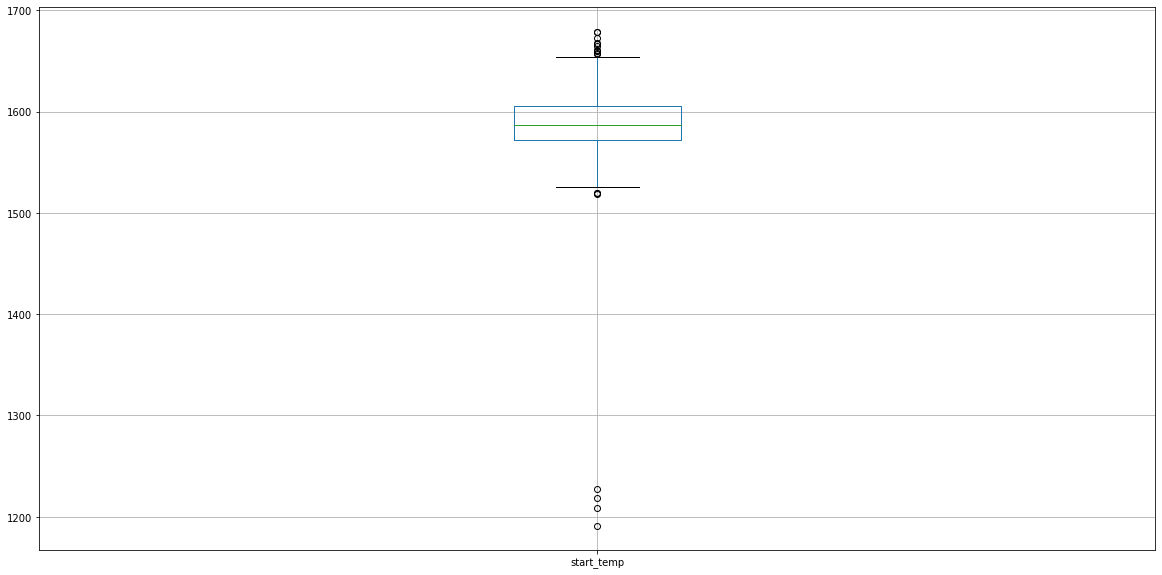

In [46]:
data_steel.boxplot(column='start_temp', figsize=(20,10))

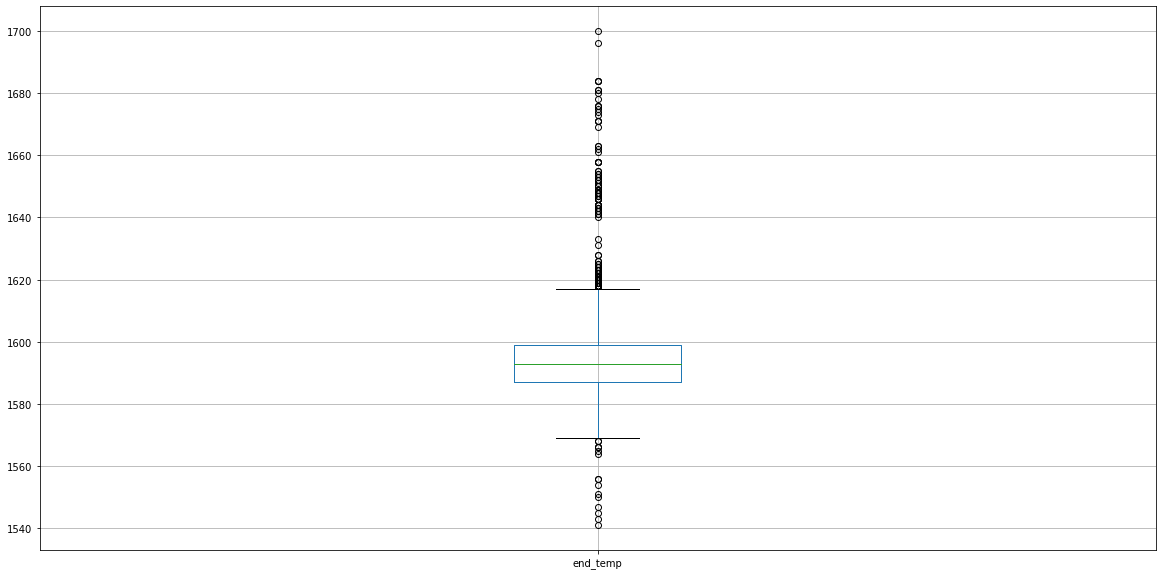

In [47]:
data_steel.boxplot(column='end_temp', figsize=(20,10))

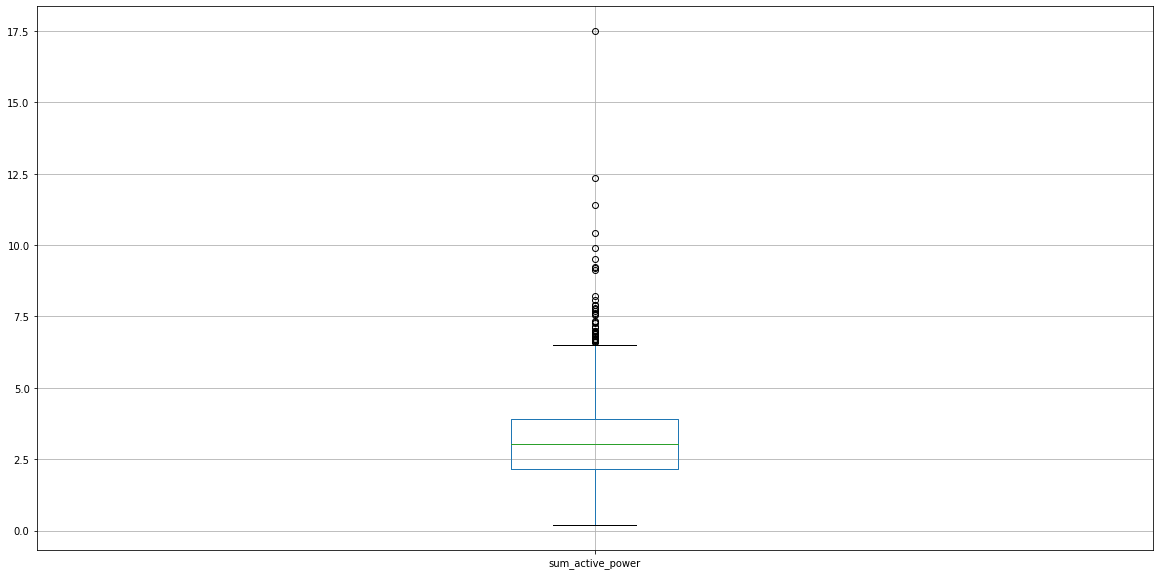

In [48]:
data_steel.boxplot(column='sum_active_power', figsize=(20,10))

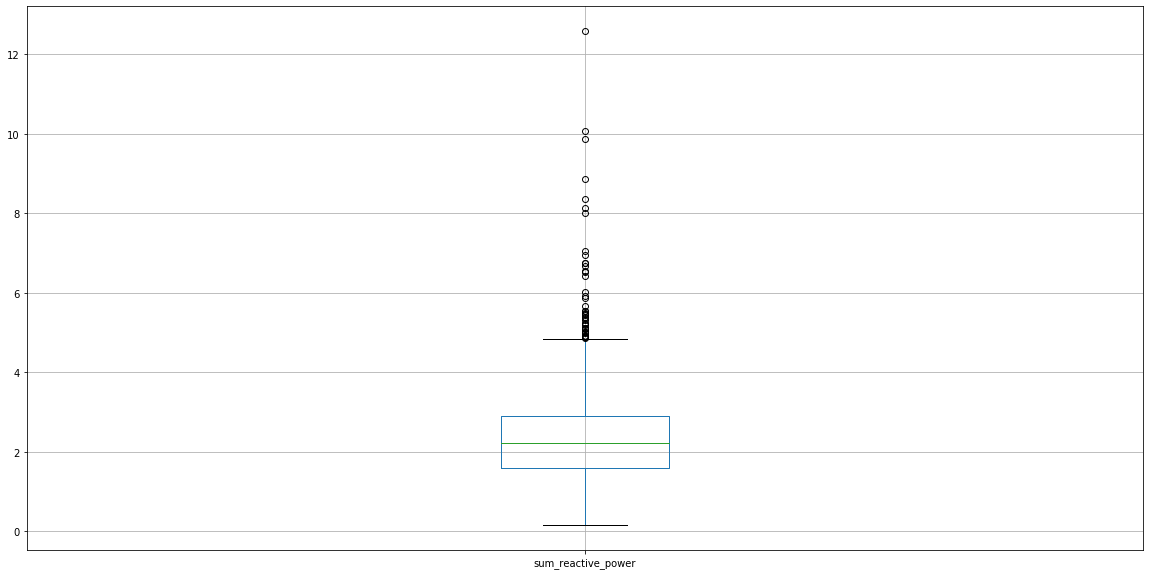

In [49]:
data_steel.boxplot(column='sum_reactive_power', figsize=(20,10))

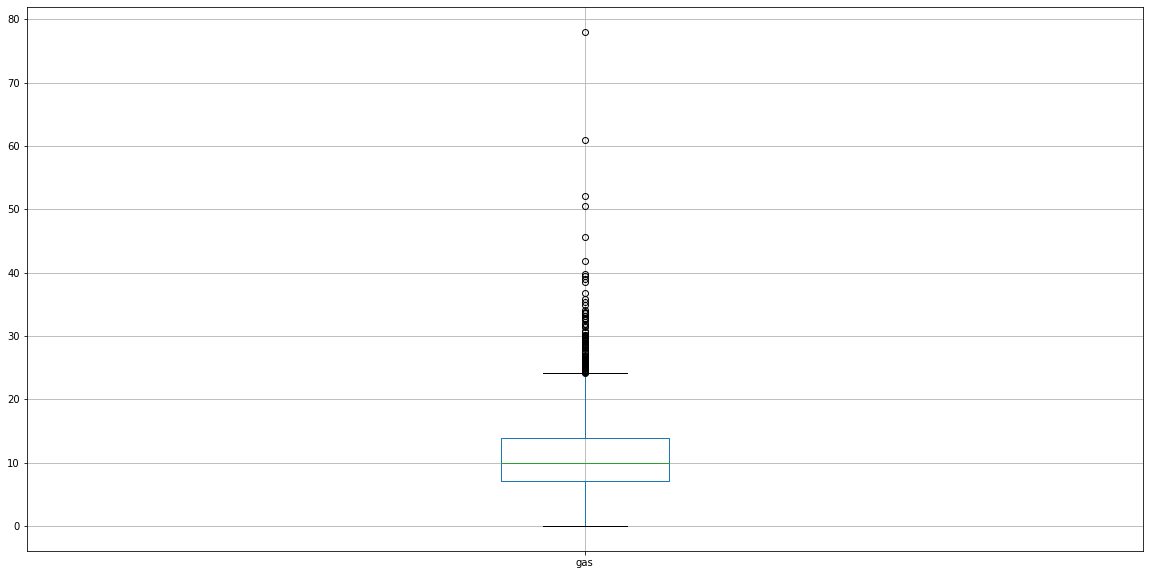

In [50]:
data_steel.boxplot(column='gas', figsize=(20,10))

Проведем оценку мультиколлинеарности и отсутсвие зависимостей между целевым признаком и остальными.

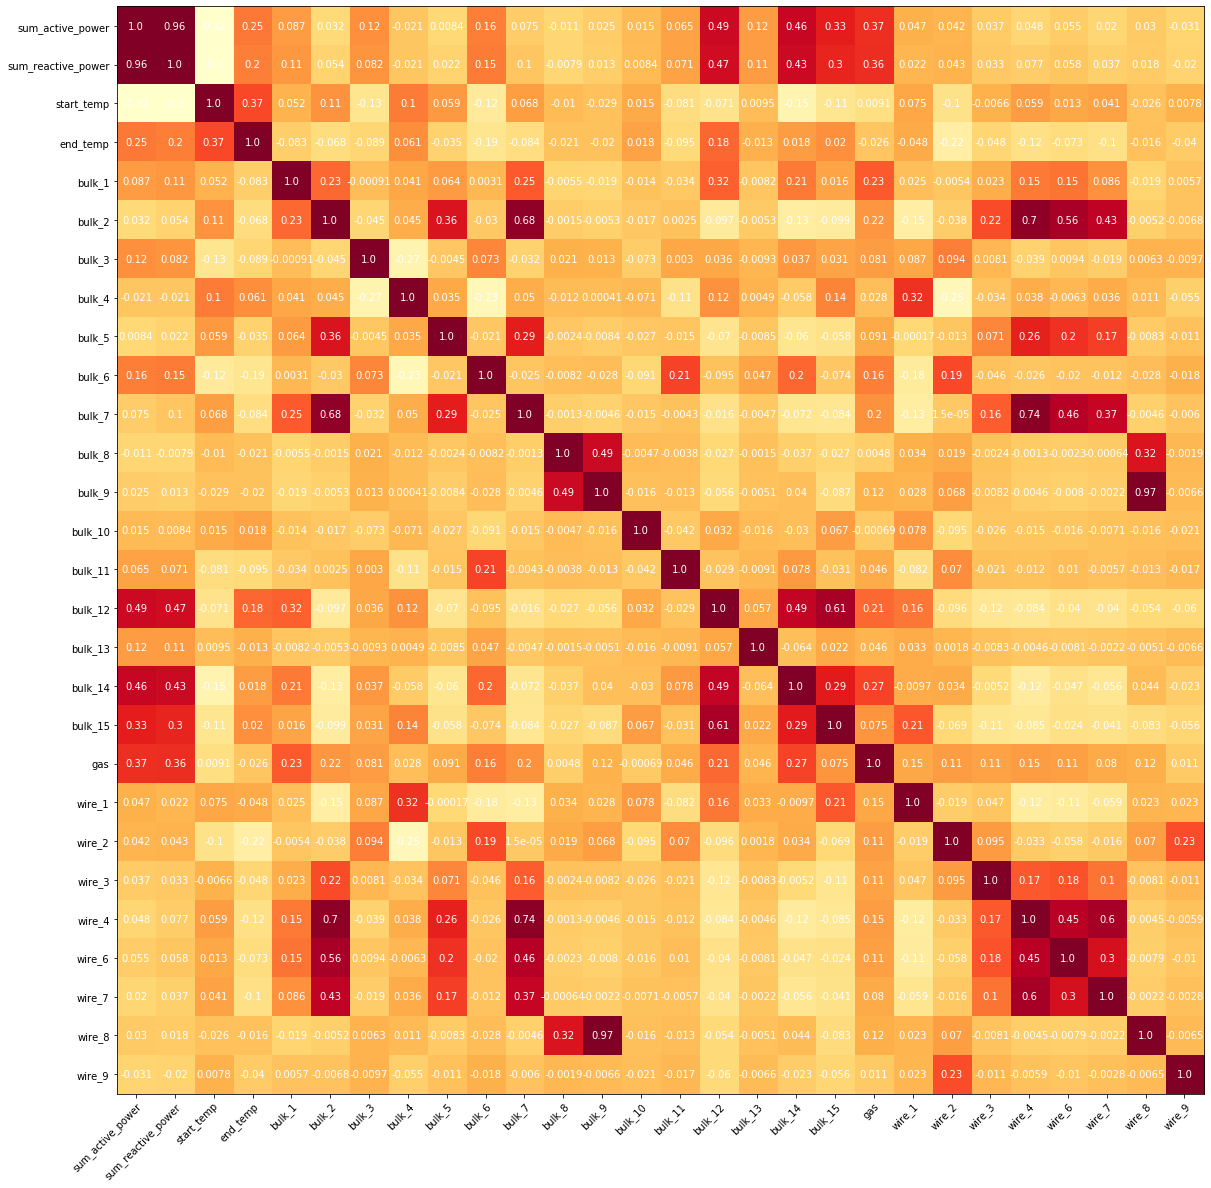

In [51]:
data_steel_knn = data_steel.copy()
corr_heatmap_data = data_steel_knn.corr()

fig, ax = plt.subplots(figsize=(20,20))
ax.set_xticks(np.arange(len(corr_heatmap_data.index)))
ax.set_yticks(np.arange(len(corr_heatmap_data.index)))

ax.set_xticklabels(corr_heatmap_data.index)
ax.set_yticklabels(corr_heatmap_data.index)

plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

data = corr_heatmap_data.values

for i in range(len(corr_heatmap_data.index)):
    for j in range(len(corr_heatmap_data.index)):
        text = ax.text(j, i, '{:.2}'.format(data[i, j]),
                       ha="center", va="center", color="w")
        
im = ax.imshow(corr_heatmap_data.corr(), cmap='YlOrRd')

Из heatmap видно, что есть сильные прямые зависимости между sum_active_power и sum_reactive_power и bulk_9 и wire_8. Так как они дублируют по сути друг друга, удалим из обучения sum_reactive_power и wire_8.

In [52]:
data_steel_knn = data_steel_knn.drop(['sum_reactive_power', 'wire_8'], axis=1)

Оценим, какие столбцы влияют на результат end_temp.

In [53]:
data_steel_knn.corr()['end_temp']

sum_active_power    0.247650
start_temp          0.366398
end_temp            1.000000
bulk_1             -0.082638
bulk_2             -0.067612
bulk_3             -0.088806
bulk_4              0.061157
bulk_5             -0.034697
bulk_6             -0.188054
bulk_7             -0.084039
bulk_8             -0.021390
bulk_9             -0.020254
bulk_10             0.018222
bulk_11            -0.095105
bulk_12             0.180171
bulk_13            -0.012884
bulk_14             0.017625
bulk_15             0.019843
gas                -0.025723
wire_1             -0.048129
wire_2             -0.215639
wire_3             -0.048014
wire_4             -0.121044
wire_6             -0.073452
wire_7             -0.100990
wire_9             -0.039511
Name: end_temp, dtype: float64

Теперь очевидно, что не все столбцы значимо влияют на данные. Для выявления аномалий возьмем зависимости с корреляцией больше 10%

In [54]:
data_steel_knn.corr()['end_temp'].abs() >= 0.1

sum_active_power     True
start_temp           True
end_temp             True
bulk_1              False
bulk_2              False
bulk_3              False
bulk_4              False
bulk_5              False
bulk_6               True
bulk_7              False
bulk_8              False
bulk_9              False
bulk_10             False
bulk_11             False
bulk_12              True
bulk_13             False
bulk_14             False
bulk_15             False
gas                 False
wire_1              False
wire_2               True
wire_3              False
wire_4               True
wire_6              False
wire_7               True
wire_9              False
Name: end_temp, dtype: bool

In [55]:
model = KNN()
data_steel_have_anomaly = data_steel_knn[['sum_active_power',
                                          'start_temp',
                                          'end_temp',
                                          'bulk_6',
                                          'bulk_12',
                                          'wire_2',
                                          'wire_4',
                                          'wire_7']]
model.fit(data_steel_have_anomaly)
data_steel_have_anomaly['is_outlier'] =  model.predict(data_steel_have_anomaly) == 1
outliers_knn = data_steel_have_anomaly['is_outlier'].sum()
print("Количество аномалий (KNN): ", outliers_knn)

outlier_indexes = list(data_steel_have_anomaly[data_steel_have_anomaly['is_outlier'] == 1].index)
good_indexes = list(set(data_steel_have_anomaly.index) - set(outlier_indexes))

data_steel_knn = data_steel_knn.drop(outlier_indexes)
data_steel_knn.shape

Количество аномалий (KNN):  196


(2148, 26)

### Промежуточный вывод

Данные были подготовлены для обучения к модели. Целевым признаком является столбец end_temp. Остальные столбцы будут использованы для предсказания.

## Обучение модели

Разделим данные на train и test к соотношению 75/25. Выберем количество кросс-валидаций равным 5

In [56]:
random_state = 4102020
# features = data_steel.drop('end_temp', axis=1)
# target = data_steel['end_temp']

features = data_steel_knn.drop('end_temp', axis=1)
target = data_steel_knn['end_temp']

features_train, features_test, target_train, target_test = train_test_split(
                                                            features, 
                                                            target, 
                                                            test_size=0.25, 
                                                            random_state=random_state)
cv_counts = 5

Выберем следующие модели.

- LinearRegression
- RandomForestRegressor
- CatBoostRegressor
- LGBMRegressor
- XGBRegressor

### LinearRegression

In [57]:
%%time

regressor = LinearRegression()
print('# Train for mean_absolute_error')
print()
cv_MAE_LR = (cross_val_score(regressor, 
                             features_train, 
                             target_train, 
                             cv=cv_counts, 
                             scoring='neg_mean_absolute_error').mean() * -1)
print('Mean MAE from CV of LinearRegression =', cv_MAE_LR)

# Train for mean_absolute_error

Mean MAE from CV of LinearRegression = 7.509622371437518
CPU times: user 187 ms, sys: 90.1 ms, total: 277 ms
Wall time: 260 ms


### RandomForestRegressor

In [58]:
%%time

regressor = RandomForestRegressor() 
hyperparams = [{'criterion':['mse'],
                'n_estimators':[x for x in range(100, 1001, 50)], 
                'random_state':[random_state]}]
# hyperparams = [{'criterion':['mse'],
#                 'n_estimators':[300], 
#                 'random_state':[random_state]}]

print('# Tuning hyper-parameters for mean_absolute_error')
print()
clf = GridSearchCV(regressor, hyperparams, scoring='neg_mean_absolute_error', cv=cv_counts)
clf.fit(features_train, target_train)
print("Best parameters set found on development set:")
print()
best_params_RFR = clf.best_params_
print(clf.best_params_)
print()
print("Grid scores on development set:")
print()
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.6f for %r"% ((mean*-1), params))
print()

cv_MAE_RFR = (max(means)*-1)

# Tuning hyper-parameters for mean_absolute_error

Best parameters set found on development set:

{'criterion': 'mse', 'n_estimators': 200, 'random_state': 4102020}

Grid scores on development set:

6.018125 for {'criterion': 'mse', 'n_estimators': 100, 'random_state': 4102020}
6.013031 for {'criterion': 'mse', 'n_estimators': 150, 'random_state': 4102020}
6.003277 for {'criterion': 'mse', 'n_estimators': 200, 'random_state': 4102020}
6.005631 for {'criterion': 'mse', 'n_estimators': 250, 'random_state': 4102020}
6.007813 for {'criterion': 'mse', 'n_estimators': 300, 'random_state': 4102020}
6.014497 for {'criterion': 'mse', 'n_estimators': 350, 'random_state': 4102020}
6.018430 for {'criterion': 'mse', 'n_estimators': 400, 'random_state': 4102020}
6.024043 for {'criterion': 'mse', 'n_estimators': 450, 'random_state': 4102020}
6.025673 for {'criterion': 'mse', 'n_estimators': 500, 'random_state': 4102020}
6.022279 for {'criterion': 'mse', 'n_estimators': 550, 'random_state': 4102020}
6

### CatBoostRegressor

In [59]:
%%time

regressor = CatBoostRegressor(verbose=False, random_state=random_state)
print('# Train for mean_absolute_error')
print()
cv_MAE_CBR = (cross_val_score(regressor, 
                             features_train, 
                             target_train, 
                             cv=cv_counts, 
                             scoring='neg_mean_absolute_error').mean() * -1)
print('Mean MAE from CV of CatBoostRegressor =', cv_MAE_CBR)

# Train for mean_absolute_error

Mean MAE from CV of CatBoostRegressor = 5.724281405164011
CPU times: user 1min 12s, sys: 9.06 s, total: 1min 21s
Wall time: 1min 28s


In [60]:
best_params_CBR = CatBoostRegressor(verbose=False, 
                                    random_state=random_state).fit(features_train, 
                                        target_train).get_all_params()
best_params_CBR

{'nan_mode': 'Min',
 'eval_metric': 'RMSE',
 'iterations': 1000,
 'sampling_frequency': 'PerTree',
 'fold_permutation_block': 0,
 'leaf_estimation_method': 'Newton',
 'boosting_type': 'Plain',
 'feature_border_type': 'GreedyLogSum',
 'bayesian_matrix_reg': 0.1000000015,
 'l2_leaf_reg': 3,
 'random_strength': 1,
 'rsm': 1,
 'boost_from_average': True,
 'model_size_reg': 0.5,
 'approx_on_full_history': False,
 'subsample': 0.8000000119,
 'use_best_model': False,
 'random_seed': 4102020,
 'depth': 6,
 'has_time': False,
 'fold_len_multiplier': 2,
 'border_count': 254,
 'classes_count': 0,
 'sparse_features_conflict_fraction': 0,
 'leaf_estimation_backtracking': 'AnyImprovement',
 'best_model_min_trees': 1,
 'model_shrink_rate': 0,
 'loss_function': 'RMSE',
 'learning_rate': 0.02999999933,
 'score_function': 'Cosine',
 'task_type': 'CPU',
 'leaf_estimation_iterations': 1,
 'bootstrap_type': 'MVS',
 'permutation_count': 4}

### LGBMRegressor

In [61]:
%%time

regressor = LGBMRegressor() 
hyperparams = [{'num_leaves':[x for x in range(10,31)], 
                'learning_rate':[x/100 for x in range(1, 11)],
                'random_state':[random_state]}]
# hyperparams = [{'num_leaves':[15], 
#                 'learning_rate':[0.05],
#                 'random_state':[random_state]}]


print('# Tuning hyper-parameters for mean_absolute_error')
print()
clf = GridSearchCV(regressor, hyperparams, scoring='neg_mean_absolute_error', cv=cv_counts)
clf.fit(features_train, target_train)
print("Best parameters set found on development set:")
print()
best_params_LGBMR = clf.best_params_
print(clf.best_params_)
print()
print("Grid scores on development set:")
print()
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.6f for %r"% ((mean*-1), params))
print()

cv_MAE_LGBMR = (max(means)*-1)

# Tuning hyper-parameters for mean_absolute_error

Best parameters set found on development set:

{'learning_rate': 0.06, 'num_leaves': 12, 'random_state': 4102020}

Grid scores on development set:

7.450506 for {'learning_rate': 0.01, 'num_leaves': 10, 'random_state': 4102020}
7.416361 for {'learning_rate': 0.01, 'num_leaves': 11, 'random_state': 4102020}
7.373566 for {'learning_rate': 0.01, 'num_leaves': 12, 'random_state': 4102020}
7.342678 for {'learning_rate': 0.01, 'num_leaves': 13, 'random_state': 4102020}
7.324442 for {'learning_rate': 0.01, 'num_leaves': 14, 'random_state': 4102020}
7.307732 for {'learning_rate': 0.01, 'num_leaves': 15, 'random_state': 4102020}
7.290883 for {'learning_rate': 0.01, 'num_leaves': 16, 'random_state': 4102020}
7.267334 for {'learning_rate': 0.01, 'num_leaves': 17, 'random_state': 4102020}
7.253321 for {'learning_rate': 0.01, 'num_leaves': 18, 'random_state': 4102020}
7.238371 for {'learning_rate': 0.01, 'num_leaves': 19, 'random_state': 4102020}
7

### XGBRegressor

In [62]:
%%time

regressor = XGBRegressor() 
hyperparams = [{'learning_rate':[x/100 for x in range(1, 51)],
                'random_state':[random_state],
                 'silent':[True]}]
# hyperparams = [{'num_leaves':[100], 
#                 'learning_rate':[0.16],
#                 'random_state':[random_state],
#                  'silent':[True]}]


print('# Tuning hyper-parameters for mean_absolute_error')
print()
clf = GridSearchCV(regressor, hyperparams, scoring='neg_mean_absolute_error', cv=cv_counts)
clf.fit(features_train, target_train)
print("Best parameters set found on development set:")
print()
best_params_XGBR = clf.best_params_
print(clf.best_params_)
print()
print("Grid scores on development set:")
print()
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.6f for %r"% ((mean*-1), params))
print()

cv_MAE_XGBR = (max(means)*-1)

# Tuning hyper-parameters for mean_absolute_error

Best parameters set found on development set:

{'learning_rate': 0.14, 'random_state': 4102020, 'silent': True}

Grid scores on development set:

584.377410 for {'learning_rate': 0.01, 'random_state': 4102020, 'silent': True}
211.950954 for {'learning_rate': 0.02, 'random_state': 4102020, 'silent': True}
76.201764 for {'learning_rate': 0.03, 'random_state': 4102020, 'silent': True}
27.225295 for {'learning_rate': 0.04, 'random_state': 4102020, 'silent': True}
10.469472 for {'learning_rate': 0.05, 'random_state': 4102020, 'silent': True}
6.593179 for {'learning_rate': 0.06, 'random_state': 4102020, 'silent': True}
5.992456 for {'learning_rate': 0.07, 'random_state': 4102020, 'silent': True}
5.941149 for {'learning_rate': 0.08, 'random_state': 4102020, 'silent': True}
5.893018 for {'learning_rate': 0.09, 'random_state': 4102020, 'silent': True}
5.854120 for {'learning_rate': 0.1, 'random_state': 4102020, 'silent': True}
5.846253 for {'le

### Промежуточный вывод

Были выбраны и обучены модели для предсказания финальной температуры. Произведен поиск гиперпараметров для получения лучшего результата.

## Тестирование моделей

Протестируем все модели для оценки их эффективности. Качественной оценкой будем считать выполнения двух условий:

- Минимальный показатель МАЕ < 8.7
- Идеальный показатель МАЕ < 6.

In [63]:
%%time

model = LinearRegression()
model.fit(features_train, target_train)
target_predict = model.predict(features_test)
test_MAE_LR = mean_absolute_error(target_predict, target_test)
print('MAE on test for LinearRegression =', test_MAE_LR)

MAE on test for LinearRegression = 7.302969806204235
CPU times: user 38.5 ms, sys: 12.7 ms, total: 51.2 ms
Wall time: 51.5 ms


In [64]:
%%time

model = RandomForestRegressor()
model.set_params(**best_params_RFR)
model.fit(features_train, target_train)
target_predict = model.predict(features_test)
test_MAE_RFR = mean_absolute_error(target_predict, target_test)
print('MAE on test of RandomForestRegressor =', test_MAE_RFR)

MAE on test of RandomForestRegressor = 5.54326815642458
CPU times: user 2.28 s, sys: 15 ms, total: 2.3 s
Wall time: 2.41 s


In [65]:
%%time

model = CatBoostRegressor(verbose=False)
model.set_params(**best_params_CBR)
model.fit(features_train, target_train)
target_predict = model.predict(features_test)
test_MAE_CBR = mean_absolute_error(target_predict, target_test)
print('MAE on test of CatBoostRegressor =', test_MAE_CBR)

MAE on test of CatBoostRegressor = 5.478157190251842
CPU times: user 15.4 s, sys: 2.03 s, total: 17.4 s
Wall time: 20.3 s


In [66]:
%%time

model = LGBMRegressor()
model.set_params(**best_params_LGBMR)
model.fit(features_train, target_train)
target_predict = model.predict(features_test)
test_MAE_LGBMR = mean_absolute_error(target_predict, target_test)
print('MAE on test of LGBMRegressor =', test_MAE_LGBMR)

MAE on test of LGBMRegressor = 5.472878756198251
CPU times: user 127 ms, sys: 8.1 ms, total: 135 ms
Wall time: 153 ms


In [67]:
%%time

model = XGBRegressor()
model.set_params(**best_params_XGBR)
model.fit(features_train, target_train)
target_predict = model.predict(features_test)
test_MAE_XGBR = mean_absolute_error(target_predict, target_test)
print('MAE on test of XGBRegressor =', test_MAE_XGBR)

MAE on test of XGBRegressor = 5.4584193
CPU times: user 196 ms, sys: 3.95 ms, total: 200 ms
Wall time: 210 ms


In [68]:
index = ['LinearRegression',
         'RandomForestRegressor',
         'CatBoostRegressor',
         'LGBMRegressor',
         'XGBRegressor']
data = {'MAE на CV':[cv_MAE_LR,
                     cv_MAE_RFR,
                     cv_MAE_CBR,
                     cv_MAE_LGBMR,
                     cv_MAE_XGBR],
        'MAE на тесте':[test_MAE_LR,
                        test_MAE_RFR,
                        test_MAE_CBR,
                        test_MAE_LGBMR,
                        test_MAE_XGBR]}

scores_data = pd.DataFrame(data=data, index=index)
scores_data['Выполнение минимальной задачи'] = scores_data['MAE на тесте'] <= 8.7
scores_data['Выполнение идеальной задачи'] = scores_data['MAE на тесте'] <= 6
scores_data

,MAE на CV,MAE на тесте,Выполнение минимальной задачи,Выполнение идеальной задачи
LinearRegression,7.509622,7.302970,True,False
RandomForestRegressor,6.003277,5.543268,True,True
CatBoostRegressor,5.724281,5.478157,True,True
LGBMRegressor,5.927509,5.472879,True,True
XGBRegressor,5.770514,5.458419,True,True


## Заключительный вывод

В ходе работы произведены следующие шаги:

- Были подготовлены данные, изменены типы данных, определены и использованы номера партий, у которых есть замеры по температуре.
- Были подготовлены признаки, сформирована единая таблица со всеми данными для модели. Выделен целевой признак как последний замер в серии замеров. Разделены на features и target.
- Проведен выбор модели, использованы и обучены регрессионные модели.
- По результатам проведена оценка эффективности моделей на тестовой выборке.

В итоге наилучшей моделью по метрике MAE = 5.46 стала модель XGBRegressor. Этот результат показывает, что модель в среднем ошибается на 5-6 градусов температуры. Модели LGBMRegressor, RandomForestRegressor и CatBoostRegressor получили решение идеальной задачи. LinearRegression не может ее выполнить из-за отсуствия необходимых нелинейных связей.

### Анализ значимости входных параметров

In [69]:
predictors = [x for x in features_train.columns]
feature_importances = pd.DataFrame(data=clf.best_estimator_.feature_importances_, index=predictors, columns=['importance'])

In [70]:
feature_importances.sort_values(by='importance', ascending=False, inplace=True)

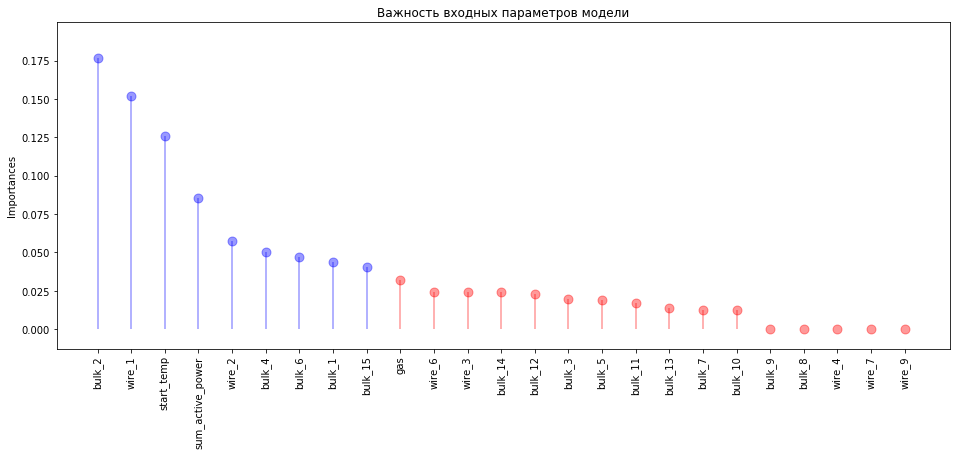

In [71]:
x = feature_importances.index
y = feature_importances['importance']
fig = plt.figure(figsize = (16, 6))
ax = fig.add_subplot()
for x_, y_ in zip(x, y):
    ax.scatter(x_, y_, color = "red" if y_ < y.mean() else "blue", alpha = 0.4, s = 80)
    ax.vlines(x_, ymin = 0, ymax = y_, color = "red" if y_ < y.mean() else "blue", alpha = 0.4)
ax.set_xticklabels(x, rotation = 90)
ax.set_ylabel("Importances")
ax.set_title("Важность входных параметров модели");

Мне была поставлена задача оптимизации производственных расходов Металлургического комбината ООО «Так закаляем сталь» путем уменьшения потребления электроэнергии на этапе обработки стали. В качестве вводных, Заказчиком было предоставлено 7 файлов с данными по каждому этапу обработки, на основе которых строились модели, предсказывающую финальный замер температуры стали. Качество модели оценивалась метрикой Mean Absolute Error (MAE).

Был составлен следующий план работы:

* Подготовка и анализ данных
    * Импортируем необходимые библиотеки
    * Загрузим датасет
    * Проведем первичный осмотр датасета
    * Определим пропуски и дубликаты
    * Проверим данные на аномальность

* Предобработка данных
    * Заполним пропуски
    * Изменим формат данных в некоторых столбцах если потребуется
    * Уберем объекты, не имеющие достаточно признаков для изучения если потребуется
    * Проверим признаки на мультиколлиниарность

* Обучение моделей
    * Затем, подготовим датасет для обучения
    * Определим целевой признак
    * Поделим датасет на выборки: Обучающаю и тестовую
    * Выберем 3 модели для работы: Linear Regression, Random Forest, LGBMRegression
    * Обучим каждую модель и предскажем на тестовой выборке
    * Сравним результаты по метрике MAE
    * Определим важность признаков для каждой модели
    
* Вывод
    * Определим лучшую модель и результат метрики
    * На основе анализа сформируем доводы и напишем вывод

Работа произведена по плану с небольшими корректировками, были добавлены еще модели для работы  XGBRegressor и CatBoostRegressor.

Использованы следующие библиотеки:
Pandas, Numpy, Sklearn, CatBoost, LightGBM, Matplotlib.pyplot, Seaborn

В ходе работы стоило уделить больше внимание на важность признаков для каждой модели, данное замечание учтено.

В итоге наилучшей моделью по метрике MAE = 5.46 стала модель XGBRegressor. Этот результат показывает, что модель в среднем ошибается на 5-6 градусов температуры. Модели LGBMRegressor, RandomForestRegressor и CatBoostRegressor получили решение идеальной задачи. LinearRegression не может ее выполнить из-за отсуствия необходимых нелинейных связей.